In [3]:
import os
import numpy as np
import random as python_random
SEED=56789
np.random.seed(SEED)
python_random.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import pandas as pd
import numpy as np
import random
import pickle
import optuna
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, PandasTools
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem.Draw import IPythonConsole
from IPython.core.display import display, HTML

#import libraries
import sklearn.ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import model_selection
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import math
from math import sqrt
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score

from shutil import copyfile

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
df = pd.read_csv("RET_Mutant_SELECTED_TR_TS_threshold_6.0.csv")
df

,SET_ID,pIC50,RDKIT_SMILES,trainingset_class,activity_label
0,305117,7.507240,Cc1ccc(F)c(C(O)=NC2(C)CCN(c3ccc(-c4cc(OCC(C)(C...,test,1
1,305723,5.881074,COc1ccc(CC2(O)CCN(c3ccc(-c4cc(OCC(C)(C)O)cn5nc...,training,0
2,305098,6.970616,CC(C)(C)CC(O)=NC1(C)CCN(c2ccc(-c3cc(OCC(C)(C)O...,test,1
3,305083,6.995679,CC(C)(O)COc1cc(-c2ccc(N3CCC(C)(N=C(O)c4nc(O)cc...,test,1
4,296799,5.978397,CC(C)C(=O)N1CCC12CCN(c1ccc(-c3cc(OCCN4CCOCC4)c...,training,0
...,...,...,...,...,...
865,305149,7.221126,Cc1ccc(OC2CN(c3ccc(-c4cc(OCC(C)(C)O)cn5ncc(C#N...,test,1
866,305590,6.882729,CCOc1cc(-c2ccc(N3CCC(CN4CCN(C)C(C)C4)(N=C(O)Oc...,test,1
867,305241,7.052076,COc1ncc(OC2CCN(c3ccc(-c4cc(OCC(C)(C)O)cn5ncc(C...,test,1
868,305120,6.707744,Cc1ccnc(C(=O)NC2(C)CCN(c3ccc(-c4cc(OCC(C)(C)O)...,test,1


In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(df['RDKIT_SMILES'], df['pIC50'], test_size=0.2, \
                                                    random_state=42) 

In [6]:
len(X_train), len(X_test)

(696, 174)

In [7]:
def smiles_to_mols(query_smiles):
    mols = [Chem.MolFromSmiles(smile) for smile in query_smiles]
    valid = [0 if mol is None else 1 for mol in mols]
    valid_idxs = [idx for idx, boolean in enumerate(valid) if boolean == 1]
    valid_mols = [mols[idx] for idx in valid_idxs]
    return valid_mols, valid_idxs

class Descriptors:

    def __init__(self, data):
        self._data = data

    def ECFP(self, radius, nBits):
        fingerprints = []
        mols, idx = smiles_to_mols(self._data)
        fp_bits = [AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits) for mol in mols]
        for fp in fp_bits:
            fp_np = np.zeros((1, nBits), dtype=np.int32)
            DataStructs.ConvertToNumpyArray(fp, fp_np)
            fingerprints.append(fp_np)
        return fingerprints, idx

    def ECFP_counts(self, radius, useFeatures, useCounts=True):
        mols, valid_idx = smiles_to_mols(self._data)
        fps = [AllChem.GetMorganFingerprint(mol, radius, useCounts=useCounts, useFeatures=useFeatures) for mol in mols]
        size = 2048
        nfp = np.zeros((len(fps), size), np.int32)
        for i, fp in enumerate(fps):
            for idx, v in fp.GetNonzeroElements().items():
                nidx = idx % size
                nfp[i, nidx] += int(v)
        return nfp, valid_idx

    def Avalon(self, nBits):
        mols, valid_idx = smiles_to_mols(self._data)
        fingerprints = []
        fps = [pyAvalonTools.GetAvalonFP(mol, nBits=nBits) for mol in mols]
        for fp in fps:
            fp_np = np.zeros((1, nBits), dtype=np.int32)
            DataStructs.ConvertToNumpyArray(fp, fp_np)
            fingerprints.append(fp_np)
        return fingerprints, valid_idx

    def MACCS_keys(self):
        mols, valid_idx = smiles_to_mols(self._data)
        fingerprints = []
        fps = [MACCSkeys.GenMACCSKeys(mol) for mol in mols]
        for fp in fps:
            fp_np = np.zeros((1, ), dtype=np.int32)
            DataStructs.ConvertToNumpyArray(fp, fp_np)
            fingerprints.append(fp_np)
        return fingerprints, valid_idx

def get_ECFP6_counts(inp):
    if not isinstance(inp, list):
        inp = list(inp)
    desc = Descriptors(inp)
    fps, _ = desc.ECFP_counts(radius=3, useFeatures=True, useCounts=True)
    return fps

In [8]:
train_fps = get_ECFP6_counts(X_train)
test_fps = get_ECFP6_counts(X_test)

In [9]:
models_RF_train = {"RF": RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=28,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=270,
                      n_jobs=None, oob_score=False, random_state=1234,
                      verbose=0, warm_start=False)}

In [10]:
# Calculate the Training and Validation (Refined set) statistics
scores = {}
for m in models_RF_train:
    models_RF_train[m].fit(train_fps, Y_train)
    scores[m + "_train_r2"] = models_RF_train[m].score(train_fps, Y_train)
    Y_pred_train_rf = models_RF_train[m].predict(train_fps)
    scores[m + "_rmse_train"] = sqrt(mean_squared_error(Y_train, Y_pred_train_rf))
    scores[m + "_mae_train"] = mean_absolute_error(Y_train, Y_pred_train_rf)
    scores[m + "_pcc_train"] = pearsonr(Y_train, Y_pred_train_rf)
scores_RF_train = pd.Series(scores).T
scores_RF_train

RF_train_r2                        0.92931
RF_rmse_train                     0.168892
RF_mae_train                      0.128043
RF_pcc_train     (0.9732687750943457, 0.0)
dtype: object

In [11]:
# Calculate statistics for test set (Core set) based on RF model
scores = {}
for m in models_RF_train:
    Y_pred_test_rf = models_RF_train[m].predict(test_fps)
    scores[m + "_test_r2"] = r2_score(Y_test, Y_pred_test_rf)
    scores[m + "_rmse_test"] = sqrt(mean_squared_error(Y_test, Y_pred_test_rf))
    scores[m + "_mae_test"] = mean_absolute_error(Y_test, Y_pred_test_rf)
    scores[m + "_pcc_test"] = pearsonr(Y_test, Y_pred_test_rf)
scores_RF_test = pd.Series(scores).T
scores_RF_test

RF_test_r2                                         0.583048
RF_rmse_test                                       0.398254
RF_mae_test                                        0.293932
RF_pcc_test     (0.7682645808385009, 3.756029098360361e-35)
dtype: object

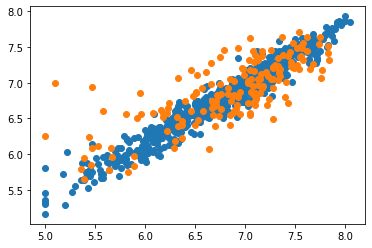

In [12]:
# Scatter plot for Random Forest Model
plt.scatter(Y_train, Y_pred_train_rf)
plt.scatter(Y_test, Y_pred_test_rf)
plt.show()

In [13]:
models_RF_final = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=28,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=270,
                      n_jobs=None, oob_score=False, random_state=1234,
                      verbose=0, warm_start=False)

# fit to all data points
complete_fps = np.concatenate((train_fps, test_fps), axis=0)
complete_y = pd.concat((Y_train, Y_test))
models_RF_final.fit(complete_fps, complete_y)
y_pred_final = models_RF_final.predict(complete_fps)
models_RF_final_r2 = r2_score(complete_y, y_pred_final)
print(models_RF_final_r2)

0.9320460555879043


In [14]:
# save the model
with open(("RET_MUTANT_final_model_Hyper.pkl"), "wb") as f:
    pickle.dump(models_RF_final, f)